# Triangulation error

In [7]:
import pickle
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

tri_error = pickle.load(open('triangulation_errors.pkl','rb'))
keys = list(tri_error.keys())
ttl_err = []
for j in [0, 1, 5]:
    ttl_err.append(np.mean(tri_error[keys[j]], axis=1))

ttl_err = pd.DataFrame(ttl_err)#.set_index(np.arange(len(ttl_err[0])))
ttl_err.columns.names = ['frame']
ttl_err.index = pd.MultiIndex.from_tuples([(6, 'coxa-femur'), (6, 'femur-tibia'), (6, 'tibia-tarsus'), (6, 'tarsus-tip'), 
                                           (5, 'coxa-femur'), (5, 'femur-tibia'), (5, 'tibia-tarsus'), (5, 'tarsus-tip'),
                                           (4, 'coxa-femur'), (4, 'femur-tibia'), (4, 'tibia-tarsus'), (4, 'tarsus-tip')],
                                         names=['num_cams', 'joint'])

ValueError: Must pass 2-d input

# Camera angle error

In [1]:
def read_convergence_info(file):
    f=open(file, "r")
    contents=f.readlines()
    epoch, lr, loss_train, loss_test, err_test = [], [], [], [], []
    for i in range(1,len(contents)):
        line = contents[i][:-1].split('\t')
        epoch.append(float(line[0]))
        lr.append(float(line[1]))
        loss_train.append(float(line[2]))
        loss_test.append(float(line[3]))
        err_test.append(float(line[4]))
        
    return epoch, lr, loss_train, loss_test, err_test

Convergence

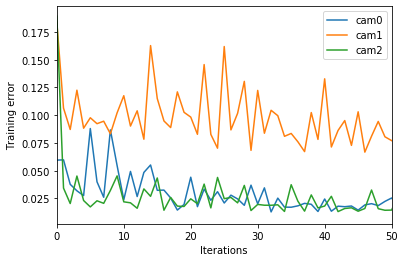

In [2]:
import matplotlib.pyplot as plt
from src.utils import filter_data
root_folder = '/data/LiftFly3D/DF3D/cam_angles/'

for cam in ['cam0', 'cam1', 'cam2']:
    epoch, lr, loss_train, loss_test, err_test = read_convergence_info(root_folder + cam +'/log_train.txt')
    plt.plot(err_test,label=cam)
    
#plt.xscale('log')
plt.xlim([0, 50])
plt.ylabel('Training error')
plt.xlabel('Iterations')
plt.legend()
plt.show()
#plt.savefig('training_error.svg')

# Behaviors

In [33]:
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

root_dir = '/data/LiftFly3D/DF3D/behaviors/'
train_dir = ['train_PR', 'train_MDN', 'train_aDN']
test_dir = ['test_PR', 'test_MDN', 'test_aDN']

ttl_err = []
for i in range(3):
    for j in range(3):
        path = os.path.join(root_dir, train_dir[i], test_dir[j])
        all_err = torch.load(path + '/test_results.pth.tar')['all_err']
        ttl_err.append(np.mean(all_err, axis=1))

ttl_err = pd.DataFrame(ttl_err)#.set_index(np.arange(len(ttl_err[0])))
ttl_err.columns.names = ['frame']
ttl_err.index = pd.MultiIndex.from_tuples([('train_PR', 'test_PR'), ('train_PR', 'test_MDN'), ('train_PR', 'test_aDN'), 
                                             ('train_MDN', 'test_PR'), ('train_MDN', 'test_MDN'), ('train_MDN', 'test_aDN'),
                                             ('train_aDN', 'test_PR'), ('train_aDN', 'test_MDN'), ('train_aDN', 'test_aDN')],
                                         names=['train', 'test'])

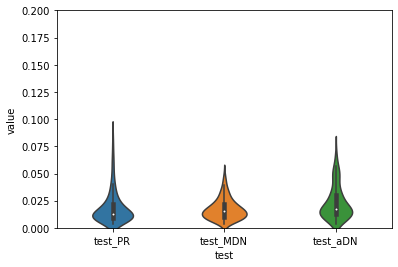

In [34]:
#train PR
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_PR',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4, width=0.4)
plt.ylim(0, 0.2)
plt.savefig('train_PR.svg')

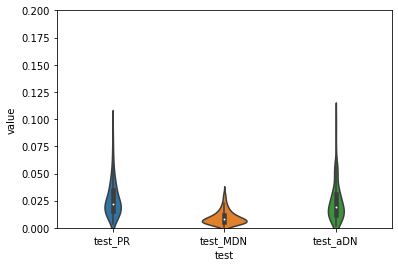

In [35]:
#train MDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_MDN',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4, width=0.4)
plt.ylim(0, 0.2)
plt.savefig('train_MDN.svg')

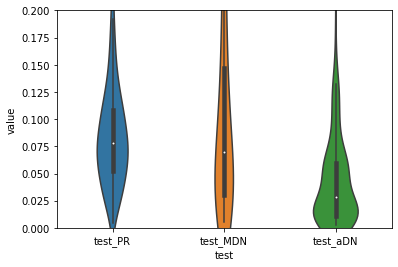

In [36]:
#train aDN
ttl_err1 = ttl_err.T
ttl_err1= ttl_err1.loc[:,('train_aDN',slice(None))]#
q = ttl_err1.quantile(q=0.98)
ttl_err1 = ttl_err1[ttl_err1<q].melt()
sns.violinplot(x="test", y="value", data=ttl_err1,bw=0.4, width=0.4)
plt.ylim(0, 0.2)
plt.savefig('train_aDN.svg')